<a href="https://colab.research.google.com/github/yusuku/DepthEstimationFrom360/blob/main/RefineMida/RefineMidas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/isl-org/MiDaS.git
%cd MiDaS
!pip install torch torchvision
!pip install timm
!pip install einops
!pip install onnx


Cloning into 'MiDaS'...
remote: Enumerating objects: 622, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 622 (delta 183), reused 139 (delta 137), pack-reused 375 (from 1)
Receiving objects: 100% (622/622), 3.44 MiB | 12.49 MiB/s, done.
Resolving deltas: 100% (246/246), done.
/content/MiDaS
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 81.6 MB/s eta 0:00:00


In [2]:
import cv2
import torch
import utils
from midas.dpt_depth import DPTDepthModel
from midas.midas_net_custom import MidasNet_small
from midas.midas_net import MidasNet
import os
import requests
import gc

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
def download_file(url, folder_path):
    # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)

    # Get the file name from the URL
    file_name = url.split("/")[-1]

    # Combine the folder path and file name to get the full file path
    file_path = os.path.join(folder_path, file_name)

    # Check if the file already exists in the folder
    if os.path.exists(file_path):
        print(f"File already downloaded: {file_path}")
    else:
        # Send an HTTP GET request to the URL
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Open the file and write the content from the response
            with open(file_path, 'wb') as file:
                file.write(response.content)
            print(f"File downloaded and saved to: {file_path}")
        else:
            print(f"Failed to download the file. HTTP status code: {response.status_code}")

In [4]:
import torch.nn.functional as F

# Custom normalization layer
class NormalizationLayer(torch.nn.Module):
    def __init__(self, mean, std):
        super(NormalizationLayer, self).__init__()
        self.mean = mean.view(1, -1, 1, 1)
        self.std = std.view(1, -1, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return (x - self.mean) / self.std


class StandardizationLayer(torch.nn.Module):
    def __init__(self):
        super(StandardizationLayer, self).__init__()

    def forward(self, x):
        # Use torch.min and torch.max instead of torch(x).min and torch(x).max
        x = x.unsqueeze(1)
        x = F.interpolate(x, size=(512, 1024), mode='bilinear', align_corners=False)
        # 他の処理
        return (x - torch.min(x)) / (torch.max(x) - torch.min(x))
# convert all models

url="https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt"
onnxFile = "weights/" +" midas_v21_small_256" + ".onnx"
download_file(url, "weights")


model_path = "weights/midas_v21_small_256.pt"
device = torch.device("cpu")


model = MidasNet_small(
    model_path,
    features=64,
    backbone="efficientnet_lite3",
    exportable=True,
    non_negative=True,
    blocks={'expand': True}
)


# specify input size

net_w, net_h = 256, 256



mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# insert normalization layer at the beginning of the model
norm_layer = NormalizationLayer(mean, std)
stn_layer=StandardizationLayer()
model = torch.nn.Sequential(norm_layer,model,stn_layer)#, model,stn_layer)


model.eval()



File downloaded and saved to: weights/midas_v21_small_256.pt
Loading weights:  weights/midas_v21_small_256.pt


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
/content/MiDaS/midas/base_model.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle dat

Sequential(
  (0): NormalizationLayer()
  (1): MidasNet_small(
    (pretrained): Module(
      (layer1): Sequential(
        (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): ReLU6(inplace=True)
            (se): Identity()
            (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act2): Identity()
          )
        )
        (4): Sequential(
          (0): InvertedResidual(
            (conv_pw): Conv2d(24, 

In [5]:
output=model(torch.rand(1, 3, 512, 1024, dtype=torch.float))
output.shape

torch.Size([1, 1, 512, 1024])

In [6]:
# 1. 画像を読み込む
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

image_path ="/content/f98f146eba5a102cb3441b0963f3c57e (1).png" # 画像のパスを指定
image = Image.open(image_path).convert('RGB')  # RGB形式に変換

# 2. リサイズとTensor変換を定義
transform = transforms.Compose([
    transforms.Resize((512, 1024)),  # 高さ512, 幅1024にリサイズ
    transforms.ToTensor()  # [0, 255] → [0.0, 1.0]に正規化
]) # [0, 255] → [0.0, 1.0]に正規化 & CHW形式に変換

# 3. 画像をTensorに変換
image_tensor = transform(image)

# 4. 次元を(1, 512, 1024)に変形
image_tensor = image_tensor.unsqueeze(0)

outputs= model(image_tensor)

image_to_display=outputs.squeeze()

In [14]:
pixel_values

array([0.11893765, 0.11893765, 0.1189481 , ..., 0.6712222 , 0.6702548 ,
       0.6702548 ], dtype=float32)

In [16]:
outputImage=image_to_display.detach().numpy()

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming outputImage is your NumPy array containing the image data

def Histogram(imagearray):
  # Flatten the array to get a 1D array of pixel values
  pixel_values = imagearray.flatten()

  # Create the histogram
  plt.hist(pixel_values, bins=256, range=(0, 1))  # Adjust bins and range as needed

  # Add labels and title
  plt.xlabel("Pixel Value")
  plt.ylabel("Frequency")
  plt.title("Histogram of Pixel Values")

  # Display the histogram
  plt.show()

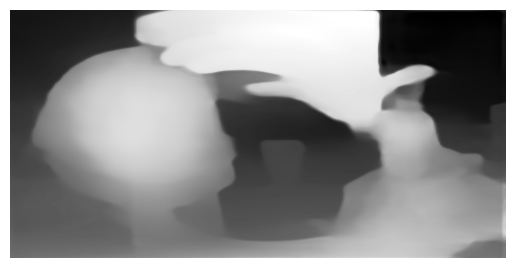

In [17]:
from skimage import exposure

# ヒストグラム平坦化を適用
img_eq = exposure.equalize_hist(outputImage)

# 結果を表示
plt.imshow(img_eq, cmap='gray')
plt.axis('off')
plt.show()

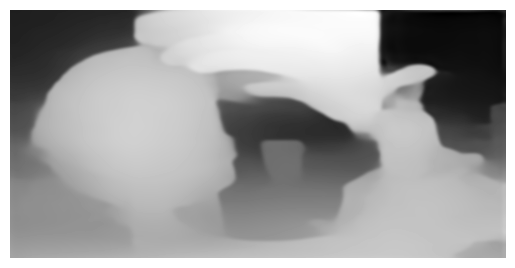

In [30]:
import cv2
depth_filtered = cv2.bilateralFilter(outputImage, 9, 75, 75)
plt.imshow(depth_filtered, cmap='gray')
plt.axis('off')
plt.show()

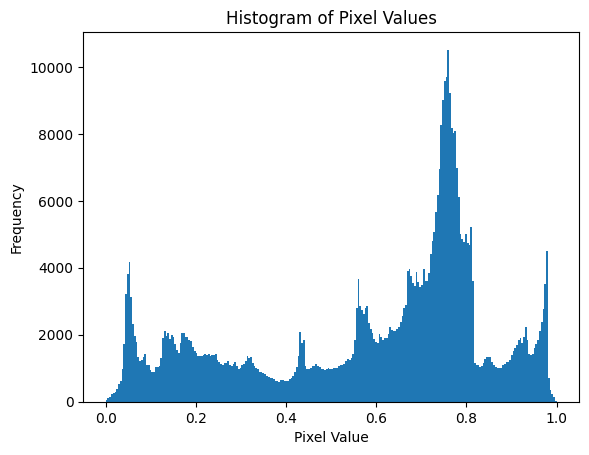

In [31]:
Histogram(depth_filtered)

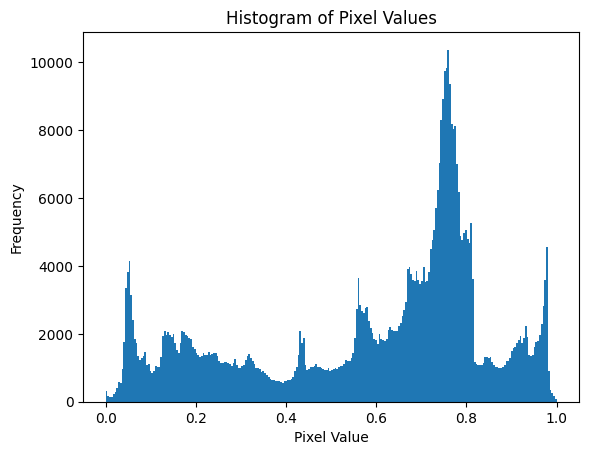

In [23]:
Histogram(outputImage)

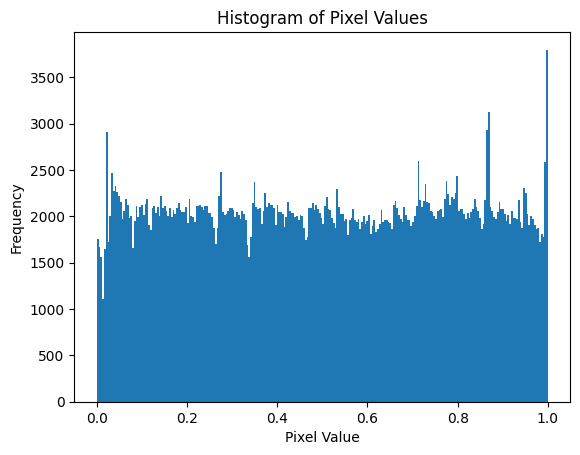

In [24]:
Histogram(img_eq)

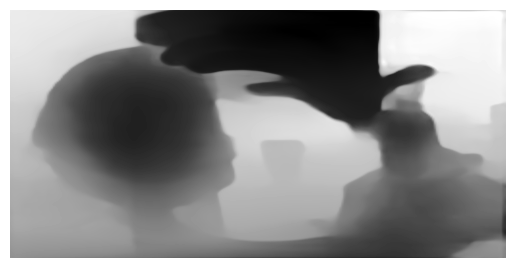

In [25]:
from skimage import exposure

# ヒストグラム平坦化を適用 (コントラストを上げる)
img_eq = exposure.equalize_hist(outputImage)

# 逆変換を適用 (ピーク周りに値を集める)
img_inv_eq = 1 - img_eq

# 結果を表示
plt.imshow(img_inv_eq, cmap='gray')
plt.axis('off')
plt.show()

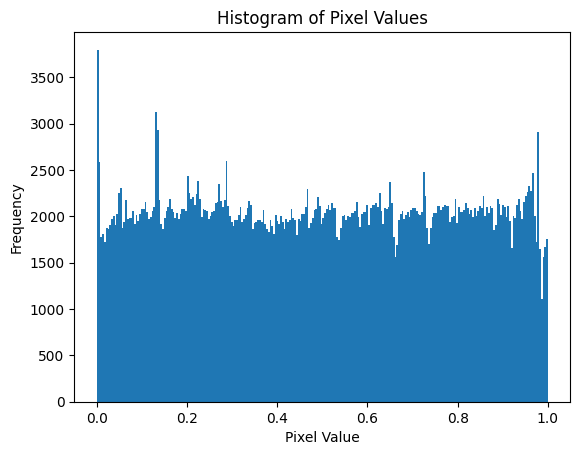

In [26]:
Histogram(img_inv_eq)

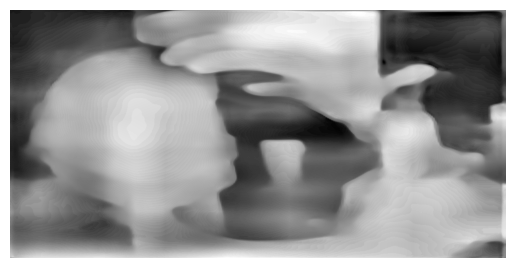

In [18]:
# AHEを適用
img_adapteq = exposure.equalize_adapthist(outputImage, clip_limit=0.03)

# 結果を表示
plt.imshow(img_adapteq, cmap='gray')
plt.axis('off')
plt.show()

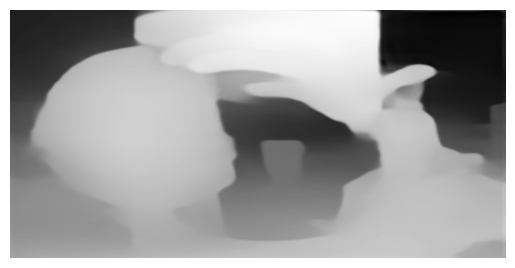

In [7]:
plt.imshow(image_to_display.detach().numpy(), cmap='gray') # Detach the tensor before converting to numpy
plt.axis('off')  # 軸を非表示
plt.show()

In [ ]:
torch.onnx.export(
    model,
    torch.rand(1, 3, 512, 1024, dtype=torch.float),
    onnxFile,
    export_params=True,
    opset_version=15,
    input_names=["input_image"],
    output_names=["output_depth"],
    do_constant_folding=True
)

# free memory
del model
gc.collect()

70

# dpt_beit_large_512


In [34]:
# @title Export all models to ONNX
import cv2
import torch
import utils
from midas.dpt_depth import DPTDepthModel
from midas.midas_net_custom import MidasNet_small
from midas.midas_net import MidasNet
import os
import requests
import gc

def download_file(url, folder_path):
    # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)

    # Get the file name from the URL
    file_name = url.split("/")[-1]

    # Combine the folder path and file name to get the full file path
    file_path = os.path.join(folder_path, file_name)

    # Check if the file already exists in the folder
    if os.path.exists(file_path):
        print(f"File already downloaded: {file_path}")
    else:
        # Send an HTTP GET request to the URL
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Open the file and write the content from the response
            with open(file_path, 'wb') as file:
                file.write(response.content)
            print(f"File downloaded and saved to: {file_path}")
        else:
            print(f"Failed to download the file. HTTP status code: {response.status_code}")

# Custom normalization layer
class NormalizationLayer(torch.nn.Module):
    def __init__(self, mean, std):
        super(NormalizationLayer, self).__init__()
        self.mean = mean.view(1, -1, 1, 1)
        self.std = std.view(1, -1, 1, 1)

    def forward(self, x):
        return (x - self.mean) / self.std

def patchUnflatten():
    import torch.nn as nn

    class View(nn.Module):
        def __init__(self, dim,  shape):
            super(View, self).__init__()
            self.dim = dim
            self.shape = shape

        def forward(self, input):
            new_shape = list(input.shape)[:self.dim] + list(self.shape) + list(input.shape)[self.dim+1:]
            return input.view(*new_shape)

    nn.Unflatten = View

model_params = [
    {
        "name": "dpt_beit_large_512",
        "path": "weights/dpt_beit_large_512.pt",
        "backbone": "beitl16_512",
        "url": "https://github.com/isl-org/MiDaS/releases/download/v3_1/dpt_beit_large_512.pt"
    }
]

modelName = "dpt_beit_large_512"
onnxFile = "weights/" + modelName + ".onnx"


download_file(model_params[0]["url"], "weights")
model_path = model_params[0]["path"]
device = torch.device("cpu")


model = DPTDepthModel(
      path=model_path,
      backbone=model_params[0]["backbone"],
      non_negative=True,
  )


net_w, net_h = 384, 384


mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

# insert normalization layer at the beginning of the model
norm_layer = NormalizationLayer(mean, std)
model = torch.nn.Sequential(norm_layer, model)

model.eval()


File already downloaded: weights/dpt_beit_large_512.pt


/content/MiDaS/midas/base_model.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load(path, map_location=torch.device('cpu'))


RuntimeError: Error(s) in loading state_dict for DPTDepthModel:
	Unexpected key(s) in state_dict: "pretrained.model.blocks.0.attn.relative_position_index", "pretrained.model.blocks.1.attn.relative_position_index", "pretrained.model.blocks.2.attn.relative_position_index", "pretrained.model.blocks.3.attn.relative_position_index", "pretrained.model.blocks.4.attn.relative_position_index", "pretrained.model.blocks.5.attn.relative_position_index", "pretrained.model.blocks.6.attn.relative_position_index", "pretrained.model.blocks.7.attn.relative_position_index", "pretrained.model.blocks.8.attn.relative_position_index", "pretrained.model.blocks.9.attn.relative_position_index", "pretrained.model.blocks.10.attn.relative_position_index", "pretrained.model.blocks.11.attn.relative_position_index", "pretrained.model.blocks.12.attn.relative_position_index", "pretrained.model.blocks.13.attn.relative_position_index", "pretrained.model.blocks.14.attn.relative_position_index", "pretrained.model.blocks.15.attn.relative_position_index", "pretrained.model.blocks.16.attn.relative_position_index", "pretrained.model.blocks.17.attn.relative_position_index", "pretrained.model.blocks.18.attn.relative_position_index", "pretrained.model.blocks.19.attn.relative_position_index", "pretrained.model.blocks.20.attn.relative_position_index", "pretrained.model.blocks.21.attn.relative_position_index", "pretrained.model.blocks.22.attn.relative_position_index", "pretrained.model.blocks.23.attn.relative_position_index". 